# <center>6. Beam Orientation Optimization (BOO) Benchmarking </center>

### This example demonstrates performing the following tasks using portpy:

1. Query the existing patients in the database
    (you first need to download the patient database from the link provided in the GitHub page).
2. Query the data provided for a specified patient in the database.
3. Create a simple IMRT plan using CVXPy package. You can call different opensource/commercial optimization engines
    from CVXPy,but you first need to download them and obtain an appropriate license.
    Most commercial optimization engines (e.g., Mosek, Gorubi) give free academic license if you have .edu email
    address
4. Use portpy_photon to create down sampled influence matrix and optimize the plan by selecting optimal beams using beam angle optimization
5. Visualise the plan (dvh, dose distribution)


In [1]:
!pip install portpy
# import sys
# sys.path.append('..')

In [2]:
import portpy.photon as pp

'0.0.5'

In [3]:
# specify the patient data location
# (you first need to download the patient database from the link provided in the GitHub page)
data_dir = r'../data'
# display the existing patients. To display it in browser rather than console, turn on in_browser=True
pp.Visualize.display_patients(data_dir=data_dir)

,patient_id,disease_site,ptv_vol_cc,num_beams,iso_center_shift
0,Lung_Patient_1,Lung,737.229,72,No
1,Lung_Phantom_Patient_2,Lung,43.902,72,No
2,Lung_Phantom_Patient_3,Lung,49.425,72,No


In [4]:
# pick a patient from the existing patient list to get detailed info about the patient data (e.g., beams_dict, structures, )
patient_id = 'Lung_Phantom_Patient_2'
beams_df = pp.Visualize.display_patient_metadata(patient_id, data_dir=data_dir, return_beams_df=True)
beams_df.head()

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


### Create plan
Create my_plan object for the planner beams.

For the customized beams_dict, you can pass the argument beam_ids
e.g. my_plan = pp.Plan(patient_name, beam_ids=[0,1,2,3,4,5,6])


In [11]:
# create my_plan object for the planner beams_dict
# for the customized beams_dict, you can pass the argument beam_ids
# e.g. my_plan = Plan(patient_name, beam_ids=[0,1,2,3,4,5,6], options=options)
# creating plan and select among the beams which are 30 degrees apart
# beam_ids = [0, 37, 42, 48, 54, 60, 66]
# beam_ids = [0, 6, 12, 18, 24, 30, 37, 42, 48, 54, 60, 66]
# beam_ids = [0, 1, 36, 37, 41, 42, 47, 48, 53, 54, 59, 60, 65, 66]
import numpy as np
beam_ids = np.arange(0, 72, 3)
plan_boo = pp.Plan(patient_id, data_dir=data_dir, beam_ids=beam_ids)

Creating BEV..
Loading sparse influence matrix...
Done


In [14]:
# create a influence matrix down sampled beamlets of width and height 5mm
down_sample_factor = [5, 5, 1]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(plan_boo.get_ct_res_xyz_mm(), down_sample_factor)]
beamlet_down_sample_factor = 4
beamlet_width_mm = plan_boo.inf_matrix.beamlet_width_mm * beamlet_down_sample_factor
beamlet_height_mm = plan_boo.inf_matrix.beamlet_height_mm * beamlet_down_sample_factor
inf_matrix_dbv = plan_boo.create_inf_matrix(beamlet_width_mm=beamlet_width_mm, beamlet_height_mm=beamlet_height_mm,
                                            opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

Creating BEV..
reindexing voxels...
Loading sparse influence matrix...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
parsing influence matrix for beam 7
parsing influence matrix for beam 8
parsing influence matrix for beam 9
parsing influence matrix for beam 10
parsing influence matrix for beam 11
parsing influence matrix for beam 12
parsing influence matrix for beam 13
parsing influence matrix for beam 14
parsing influence matrix for beam 15
parsing influence matrix for beam 16
parsing influence matrix for beam 17
parsing influence matrix for beam 18
parsing influence matrix for beam 19
parsing influence matrix for beam 20
parsing influence matrix for beam 21
parsing influence matrix for beam 22
parsing influence matrix for beam 23
creating influence matrix for down sample voxels..


### Run Optimization
- Run imrt fluence map optimization using cvxpy and one of the supported solvers and save the optimal solution in sol dictionary
- CVXPy supports several opensource (ECOS, OSQP, SCS) and commercial solvers (e.g., MOSEK, GUROBI, CPLEX)
- For optimization problems with non-linear objective and/or constraints, MOSEK often performs well
- For mixed integer programs, GUROBI/CPLEX are good choices
- If you have .edu email address, you can get free academic license for commercial solvers
- We recommend the commercial solver MOSEK as your solver for the problems in this example,
  however, if you don't have a license, you can try opensource/free solver SCS or ECOS
  see [cvxpy](https://www.cvxpy.org/tutorial/advanced/index.html) for more info about CVXPy solvers
- To set up mosek solver, you can get mosek license file using edu account and place the license file in directory C:\Users\username\mosek

#### Model Formulation

$
   \mbox{Minimize} \quad  w_o||A_{target}\mathbf{x}-pres||_{+} + w_u||A_{target}\mathbf{x}-pres||_{-} + w_{sm}(smoothness \space objective) + w_{oar}  ||A_{oar} \mathbf{x}||
$

$
\mbox{subject to}
$

$
\quad maximum(A_s\mathbf{x}) \leq {d_s}^{max}
$

$
\quad mean(A_s\mathbf{x}) \leq {d_s}^{mean}
$

$
\quad \mathbf{x}_b \leq \mathbf{y}_bM  \quad \forall b \in B
$

$
\quad \sum_{b \in B}\mathbf{y} \leq \mu
$

$
\quad \mathbf{x} \geq 0
$

$
\quad \mathbf{y}_b \in \{0,1\}
$

where $w_o$ (overdose weight) = 10000 , $w_u$ (underdose weight) = 100000, $w_{sm}$ (smoothing weight) = 1000, $w_{oar}$ (oar weight) = 10, $s$ = structure index, $pres$ = prescription dose, $\mathbf{x}$ is beamlet intensity, $\mathbf{y}_b$ is binary variable for selecting the beam, ${d_s}^{max}$ = maximum dose for structure s, ${d_s}^{mean}$ = mean dose for structure s, $A$ = influence matrix, $M$ (large number) = 1000, $\mu$ (# of beams selected) = 7.

Smoothness objective is the total quadratic variation in beamlet intensity in x and y direction. It is given by,

$
smoothness \space objective = w_r\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2 + w_l\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2
$

where $w_r$ = 0.6, $w_l$=0.4, $R_i$ and $L_i$ = right and lower neigbour of beamlet i, $b$ = beam number, $I_b$ = beamlet indices of beam $b$

In [15]:
# create cvxpy problem with max and mean dose clinical criteria and the above objective functions
prob = pp.CvxPyProb(plan_boo)

Objective Start
Objective done
Constraints Start
Structure CTV not available!
Structure BRPLX_L not available!
Structure BRPLX_R not available!
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


In [16]:
# Add constraint for selecting beams
import cvxpy as cp
st = plan_boo.inf_matrix

# binary variable for selecting beams
b = cp.Variable(len(st.beamlets_dict), boolean=True)
num_beams = 7
x = prob.x

prob.constraints += [cp.sum(b) <= num_beams]
for i in range(len(st.beamlets_dict)):
    start_beamlet = st.beamlets_dict[i]['start_beamlet']
    end_beamlet = st.beamlets_dict[i]['end_beamlet']
    M = 50  # upper bound on the beamlet intensity
    prob.constraints += [x[start_beamlet:end_beamlet] <= b[i] * M]

In [17]:
prob.solve(solver='MOSEK', verbose=True)
sol_boo = prob.get_sol()

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 17 04:10:19 PM: Your problem has 3284 variables, 35 constraints, and 0 parameters.
(CVXPY) Mar 17 04:10:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 17 04:10:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 17 04:10:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 17 04:10:19 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 17 04:10:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

(CVXPY) Mar 17 06:50:57 PM: 6419     6419     1006     18       1.0267165980e+01     6.7313240526e+00     34.44       9633.4
(CVXPY) Mar 17 06:56:57 PM: 6679     6679     1034     15       1.0267165980e+01     6.7424716819e+00     34.33       9993.0
(CVXPY) Mar 17 07:02:37 PM: 6957     6956     1066     14       1.0267165980e+01     6.7490754727e+00     34.27       10333.0
(CVXPY) Mar 17 07:07:49 PM: 7237     7236     1104     13       1.0267165980e+01     6.7747957518e+00     34.01       10645.1
(CVXPY) Mar 17 07:12:58 PM: 7516     7515     1115     14       1.0267165980e+01     6.7826286876e+00     33.94       10954.4
(CVXPY) Mar 17 07:18:23 PM: 7795     7794     1140     16       1.0267165980e+01     6.8142052157e+00     33.63       11279.0
(CVXPY) Mar 17 07:23:48 PM: 8077     8075     1174     20       1.0267165980e+01     6.8187307149e+00     33.59       11604.0
(CVXPY) Mar 17 07:29:25 PM: 8356     8354     1201     16       1.0267165980e+01     6.8334903582e+00     33.44       11

(CVXPY) Mar 18 12:56:44 AM: 24705    24655    2464     18       1.0245016351e+01     7.5860396408e+00     25.95       31580.3
(CVXPY) Mar 18 01:02:26 AM: 24982    24932    2481     20       1.0245016351e+01     7.6035700684e+00     25.78       31921.7
(CVXPY) Mar 18 01:07:23 AM: 25261    25210    2504     19       1.0245016351e+01     7.6147478449e+00     25.67       32219.2
(CVXPY) Mar 18 01:12:50 AM: 25540    25488    2523     21       1.0245016351e+01     7.6264035299e+00     25.56       32545.8
(CVXPY) Mar 18 01:18:22 AM: 25818    25765    2545     17       1.0245016351e+01     7.6368499818e+00     25.46       32877.7
(CVXPY) Mar 18 01:24:26 AM: 26095    26041    2558     21       1.0245016351e+01     7.6512132393e+00     25.32       33241.6
(CVXPY) Mar 18 01:29:49 AM: 26356    26301    2573     13       1.0245016351e+01     7.6540409502e+00     25.29       33565.3
(CVXPY) Mar 18 01:35:50 AM: 26633    26576    2588     17       1.0245016351e+01     7.6806960511e+00     25.03       

(CVXPY) Mar 18 06:35:09 AM: 43046    42841    3199     14       1.0245016351e+01     8.1499447890e+00     20.45       51884.4
(CVXPY) Mar 18 06:39:51 AM: 43327    43115    3206     22       1.0245016351e+01     8.1587091931e+00     20.36       52167.0
(CVXPY) Mar 18 06:44:41 AM: 43612    43394    3217     19       1.0245016351e+01     8.1649539902e+00     20.30       52457.1
(CVXPY) Mar 18 06:49:20 AM: 43890    43668    3227     15       1.0245016351e+01     8.1682779856e+00     20.27       52736.0
(CVXPY) Mar 18 06:54:47 AM: 44161    43937    3242     18       1.0245016351e+01     8.1808630918e+00     20.15       53063.1
(CVXPY) Mar 18 06:59:31 AM: 44439    44212    3260     19       1.0245016351e+01     8.1863009909e+00     20.09       53347.0
(CVXPY) Mar 18 07:04:13 AM: 44719    44490    3274     21       1.0245016351e+01     8.1913529191e+00     20.05       53629.0
(CVXPY) Mar 18 07:09:40 AM: 44997    44765    3290     17       1.0245016351e+01     8.2005983333e+00     19.96       

(CVXPY) Mar 18 12:02:24 PM: 61408    60961    3913     18       1.0245016351e+01     8.6256079662e+00     15.81       71519.2
(CVXPY) Mar 18 12:07:04 PM: 61690    61240    3911     13       1.0245016351e+01     8.6316004341e+00     15.75       71799.2
(CVXPY) Mar 18 12:11:56 PM: 61974    61518    3909     19       1.0245016351e+01     8.6487264669e+00     15.58       72091.4
(CVXPY) Mar 18 12:17:09 PM: 62251    61793    3900     18       1.0245016351e+01     8.6579075499e+00     15.49       72404.3
(CVXPY) Mar 18 12:22:02 PM: 62533    62072    3906     21       1.0245016351e+01     8.6641808881e+00     15.43       72697.6
(CVXPY) Mar 18 12:26:55 PM: 62813    62348    3908     17       1.0245016351e+01     8.6733704483e+00     15.34       72990.3
(CVXPY) Mar 18 12:31:25 PM: 63094    62625    3911     20       1.0245016351e+01     8.6778501832e+00     15.30       73261.1
(CVXPY) Mar 18 12:35:46 PM: 63370    62902    3901     20       1.0245016351e+01     8.6867176310e+00     15.21       

(CVXPY) Mar 18 05:28:06 PM: 79902    79195    1809     19       1.0245016351e+01     9.2506320339e+00     9.71        91062.0
(CVXPY) Mar 18 05:33:10 PM: 80175    79468    1708     19       1.0245016351e+01     9.2695981386e+00     9.52        91365.0
(CVXPY) Mar 18 05:38:27 PM: 80450    79744    1603     20       1.0245016351e+01     9.2793235593e+00     9.43        91682.1
(CVXPY) Mar 18 05:44:09 PM: 80718    80014    1521     19       1.0245016351e+01     9.2852411429e+00     9.37        92024.7
(CVXPY) Mar 18 05:49:03 PM: 80996    80293    1451     19       1.0245016351e+01     9.3025269573e+00     9.20        92318.0
(CVXPY) Mar 18 05:54:00 PM: 81270    80569    1367     16       1.0245016351e+01     9.3139259371e+00     9.09        92615.2
(CVXPY) Mar 18 05:59:29 PM: 81538    80838    1289     19       1.0245016351e+01     9.3201201962e+00     9.03        92944.8
(CVXPY) Mar 18 06:04:36 PM: 81820    81117    1241     20       1.0245016351e+01     9.3325791050e+00     8.91        

In [21]:
# Comment/Uncomment these lines to save & load plan and optimal solutions
# plan_boo = pp.load_plan(plan_name='plan_boo', path=r'C:\temp')
# sol_boo = pp.load_optimal_sol('sol_boo_ov_und', path=r'C:\temp')
# plan_planner = pp.load_plan(plan_name='plan_planner', path=r'C:\temp')
# sol_planner = pp.load_optimal_sol('sol_planner', path=r'C:\temp')
pp.save_plan(plan_boo, plan_name='plan_boo_phantom', path=r'C:\temp')
pp.save_optimal_sol(sol_boo, sol_name='sol_boo_phantom', path=r'C:\temp')

In [18]:
# Similarly, let's create plan for the planner's beams
plan_planner = pp.Plan(patient_id, data_dir=data_dir)
inf_matrix_planner_dbv = plan_planner.create_inf_matrix(beamlet_width_mm=beamlet_width_mm,
                                                        beamlet_height_mm=beamlet_height_mm,
                                                        opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

Creating BEV..
Loading sparse influence matrix...
Done
Creating BEV..
reindexing voxels...
Loading sparse influence matrix...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
creating influence matrix for down sample voxels..
Done


In [19]:
prob_planner = pp.CvxPyProb(plan_planner)
prob_planner.solve(solver='MOSEK', verbose=True)
sol_planner = prob_planner.get_sol()

Objective Start
Objective done
Constraints Start
Structure CTV not available!
Structure BRPLX_L not available!
Structure BRPLX_R not available!
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 18 07:28:58 PM: Your problem has 1945 variables, 10 constraints, and 0 parameters.
(CVXPY) Mar 18 07:28:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 18 07:28:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 18 07:28:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
----------

(CVXPY) Mar 18 07:29:01 PM: 22  1.3e-08  2.1e-06  1.2e-13  8.72e-01   1.467542251e+01   1.467542230e+01   4.1e-11  1.64  
(CVXPY) Mar 18 07:29:01 PM: 23  1.4e-08  1.7e-06  8.3e-14  4.97e-01   1.467534487e+01   1.467534471e+01   3.2e-11  1.72  
(CVXPY) Mar 18 07:29:01 PM: 24  1.2e-08  2.5e-06  2.8e-14  6.39e-01   1.467521163e+01   1.467521155e+01   1.4e-11  1.81  
(CVXPY) Mar 18 07:29:01 PM: Optimizer terminated. Time: 1.86    
(CVXPY) Mar 18 07:29:01 PM: 
(CVXPY) Mar 18 07:29:01 PM: 
(CVXPY) Mar 18 07:29:01 PM: Interior-point solution summary
(CVXPY) Mar 18 07:29:01 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Mar 18 07:29:01 PM:   Solution status : OPTIMAL
(CVXPY) Mar 18 07:29:01 PM:   Primal.  obj: 1.4675211629e+01    nrm: 1e+02    Viol.  con: 7e-06    var: 3e-06    cones: 0e+00  
(CVXPY) Mar 18 07:29:01 PM:   Dual.    obj: 1.4675211553e+01    nrm: 7e+04    Viol.  con: 0e+00    var: 3e-09    cones: 0e+00  
------------------------------------------------------------------

In [22]:
plan_planner.save_plan(plan_name='plan_planner_phantom', path=r'C:\temp')
plan_planner.save_optimal_sol(sol_planner, sol_name='sol_planner_phantom', path=r'C:\temp')
# plan_planner.save_optimal_sol(sol_planner, sol_name='sol_planner_ov_und', path=r'C:\temp')
# plan_planner = pp.load_plan(plan_name='plan_planner_phantom', path=r'C:\temp')
# sol_planner = pp.load_optimal_sol('sol_planner_phantom', path=r'C:\temp')

In [24]:
# Identifying bao and planner gantry angles
import numpy as np
bao_gantry_angles = (np.asarray(plan_boo.beams.beams_dict['gantry_angle']) + 1) * (b.value > 0)
bao_gantry_angles = bao_gantry_angles[bao_gantry_angles > 0] - 1  # add and subtract 1 to check for 0 degree angle
print('BAO gantry angles: {}'.format(bao_gantry_angles))
planner_gantry_angles = plan_planner.beams.beams_dict['gantry_angle']
print('Planner gantry angles: {}'.format(planner_gantry_angles))

obj_value_diff_per = (14.68-10.24)/(10.24)*100
print('Objective value improvement {} %'.format(obj_value_diff_per))

BAO gantry angles: [ 75  90 120 165 210 270 285]
Planner gantry angles: [0, 30, 60, 90, 120, 150, 180]
Objective value improvement 43.35937499999999 %


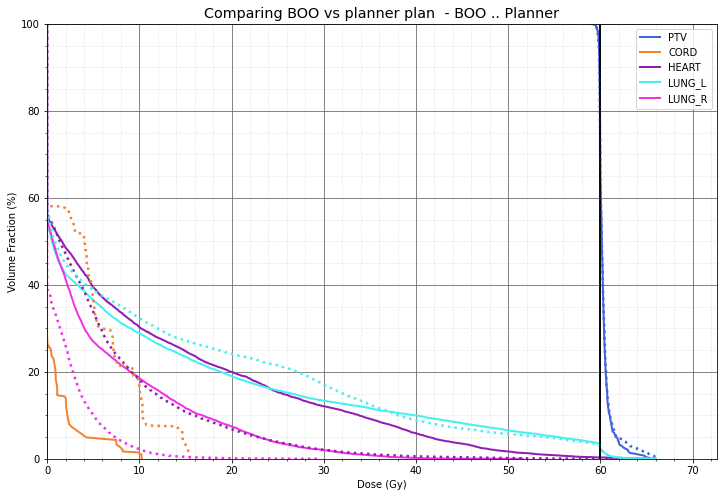

In [26]:
# plot dvh dvh for both the cases
# structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']

# To know the cost of down sampling beamlets, lets compare the dvh of down sampled beamlets with original
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD','LUNG_L','LUNG_R']
# sol_db_new = pp.sol_change_inf_matrix(sol_db, inf_matrix=sol_orig['inf_matrix'])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
ax = pp.Visualize.plot_dvh(plan_boo, sol=sol_boo, structs=structs, style='solid', ax=ax)
ax = pp.Visualize.plot_dvh(plan_planner, sol=sol_planner, structs=structs, style='dotted', ax=ax)
ax.set_title('Comparing BOO vs planner plan  - BOO .. Planner')
plt.show()